## Εισαγωγικά

In [2]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn 

In [3]:
# Set random seed for reproducibility
import random
import os
SEED = 56
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.utils import check_random_state
check_random_state(SEED)

RandomState(MT19937) at 0x1D8D8223B40

In [4]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Β. Προεπεξεργασία και Εξερεύνηση Δεδομένων

### 1. Εξερευνητική Ανάλυση Δεδομένων (EDA)

In [5]:
# Load data with pickling enabled
data = np.load(r'C:\\Users\\vasgk\\Desktop\\Μηχανική μάθηση\\Data\\breastmnist_224.npz', allow_pickle=True)

# Inspect the keys in the dataset
print("Keys in the dataset:", data.files)
print("Keys in the dataset are formatted as such:", data.files)
print("Shape of file contents: (no of contents, dimensions (224x224))")

# Print the shape of each file in the original npz file
for key in data.files:
    print(f"{key}: {data[key].shape}")

Keys in the dataset: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Keys in the dataset are formatted as such: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Shape of file contents: (no of contents, dimensions (224x224))
train_images: (546, 224, 224)
train_labels: (546, 1)
val_images: (78, 224, 224)
val_labels: (78, 1)
test_images: (156, 224, 224)
test_labels: (156, 1)


In [6]:
# Convert the data into a DataFrame
# Flatten the images and combine them with labels
train_images_flat = data['train_images'].reshape(len(data['train_images']), -1)  # Flatten 224x224 images
df_train = pd.DataFrame(train_images_flat)
df_train['Label'] = data['train_labels']

# Repeat for validation and test data, but in reverse order because the dataset's ratio is reversed
val_images_flat = data['test_images'].reshape(len(data['test_images']), -1)
df_val = pd.DataFrame(val_images_flat)
df_val['Label'] = data['test_labels']

test_images_flat = data['val_images'].reshape(len(data['val_images']), -1)
df_test = pd.DataFrame(test_images_flat)
df_test['Label'] = data['val_labels']

# Split the data into features and labels for the rest of the code
x_train = df_train.drop(columns=['Label']).values  
y_train = df_train['Label'].values.ravel()  
x_val = df_val.drop(columns=['Label']).values 
y_val = df_val['Label'].values.ravel()  
x_test = df_test.drop(columns=['Label']).values  
y_test = df_test['Label'].values.ravel()  

# save the DataFrames to CSV files SO I DONT HAVE TO RELOAD THEM EVERY TIME
#df_train.to_csv('train_data.csv', index=False)
#df_val.to_csv('val_data.csv', index=False)
#df_test.to_csv('test_data.csv', index=False)

In [7]:
# Load data, IF YOU DONT WANT TO RELOAD THE DATA, COMMENT THIS OUT
df_train = pd.read_csv('train_data.csv')
df_val = pd.read_csv('val_data.csv')
df_test = pd.read_csv('test_data.csv')

Train images shape: (546, 50176)
Train labels shape: (546,)
Missing values in training data: 0

Validation images shape: (156, 50176)
Validation labels shape: (156,)
Missing values in validation data: 0

Test images shape: (78, 50176)
Test labels shape: (78,)
Missing values in test data: 0


Total number of images: 780, (546 (70.00%) train), (156 (20.00%) val), 78 (10.00)% test)
Number of positives: 399 train, 114 val, 57 test
Percentage of positives: 73.08% train, 73.08% val, 73.08% test
Number of negatives: 147 train, 42 val, 21 test
Percentage of negatives: 26.92% train, 26.92% val, 26.92% test


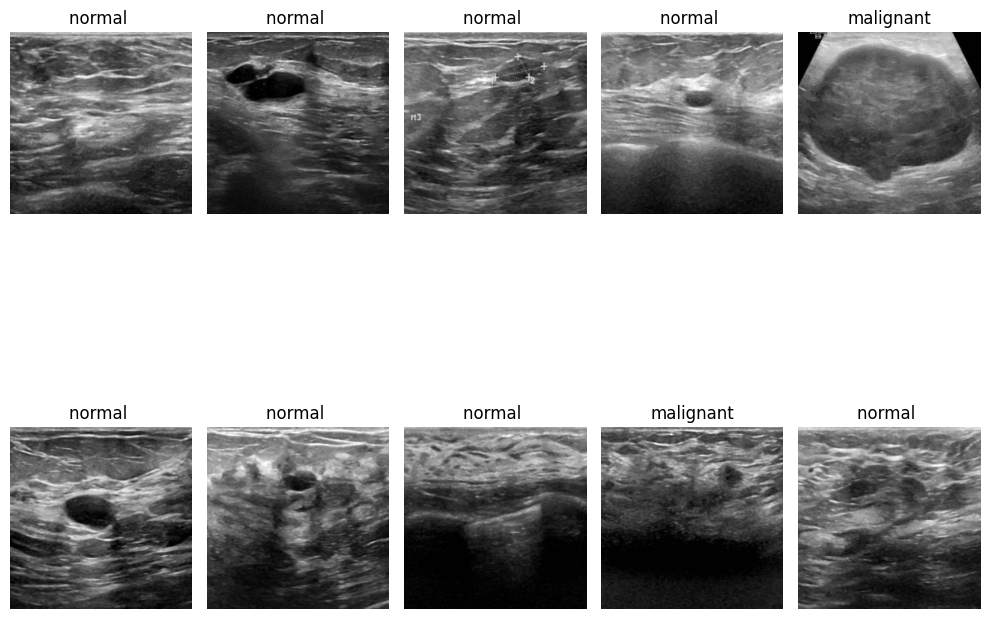

In [8]:

# Check the shapes of the arrays and DataFrames
print("Train images shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print("Missing values in training data:", df_train.isnull().sum().sum())
print()
print("Validation images shape:", x_val.shape)
print("Validation labels shape:", y_val.shape)
print("Missing values in validation data:", df_val.isnull().sum().sum())
print()
print("Test images shape:", x_test.shape)
print("Test labels shape:", y_test.shape)
print("Missing values in test data:", df_test.isnull().sum().sum())

"""# Display the first few rows of each DataFrame
print("Training DataFrame:")
print(df_train.head())

print("Validation DataFrame:")
print(df_val.head())

print("Test DataFrame:")
print(df_test.head())
"""

print("\n")
# Calculate the total number of images
num_train = len(x_train)
num_val = len(x_val)
num_test = len(x_test)
total_images = num_train + num_val + num_test
print(f"Total number of images: {total_images}, ({num_train} ({num_train /total_images * 100:.2f}%) train), ({num_val} ({num_val/total_images * 100:.2f}%) val), {num_test} ({num_test/total_images * 100:.2f})% test)")
print(f"Number of positives: {np.sum(y_train == 1)} train, {np.sum(y_val == 1)} val, {np.sum(y_test == 1)} test")
print(f"Percentage of positives: {np.mean(y_train == 1) * 100:.2f}% train, {np.mean(y_val == 1) * 100:.2f}% val, {np.mean(y_test == 1) * 100:.2f}% test")
print(f"Number of negatives: {np.sum(y_train == 0)} train, {np.sum(y_val == 0)} val, {np.sum(y_test == 0)} test")
print(f"Percentage of negatives: {np.mean(y_train == 0) * 100:.2f}% train, {np.mean(y_val == 0) * 100:.2f}% val, {np.mean(y_test == 0) * 100:.2f}% test")


# Display the first X images

images = data['train_images']
labels = data['train_labels']

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid for 10 images
    plt.imshow(images[i], cmap='gray')
    plt.title(f"{'normal ' if labels[i] == 1 else 'malignant'}")
    plt.axis('off')

plt.tight_layout()
plt.show()


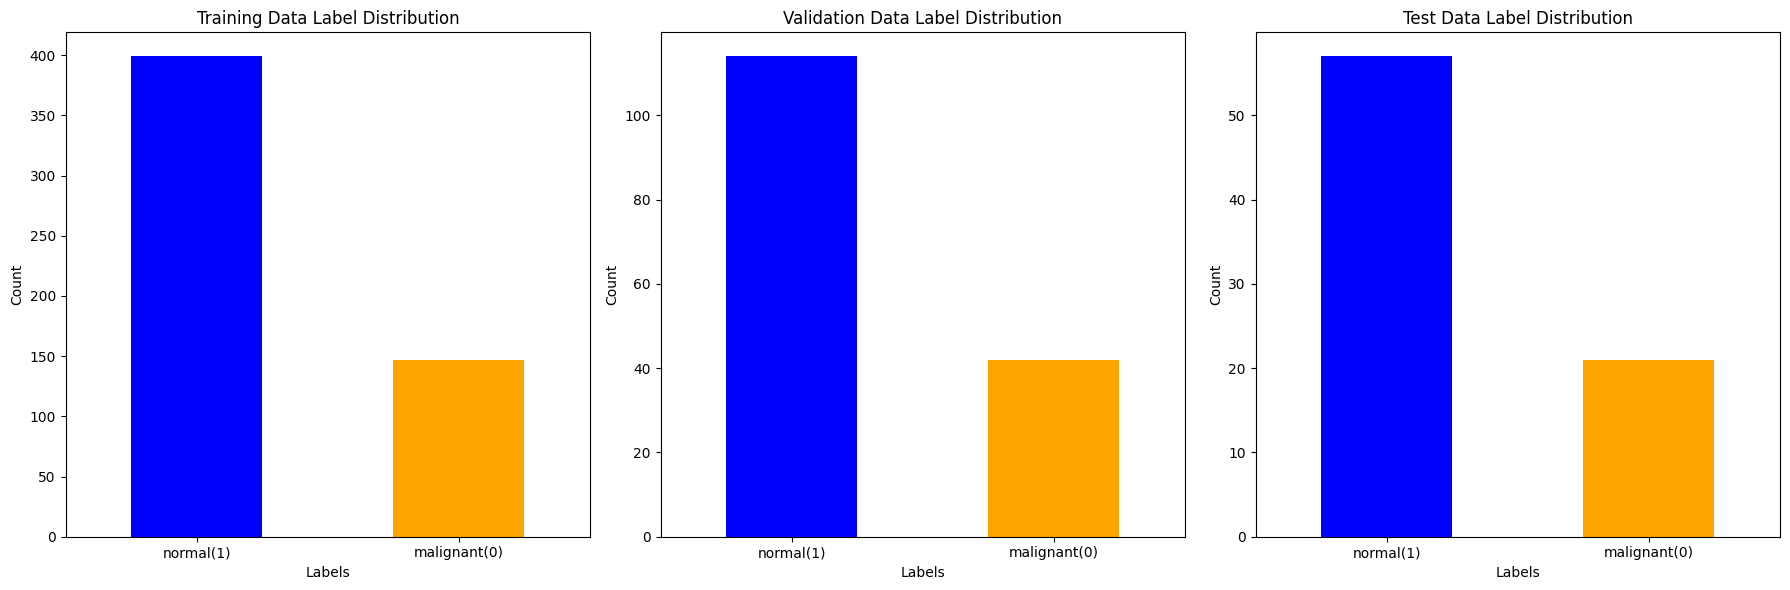

In [9]:
#PLOTS
# Convert the relevant data from the NpzFile object into a pandas DataFrame
# Create a row of 3 plots for the label distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for training data
df_train['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Training Data Label Distribution')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels

# Plot for validation data
df_val['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title('Validation Data Label Distribution')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels


# Plot for test data
df_test['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[2], color=['blue', 'orange'])
axes[2].set_title('Test Data Label Distribution')
axes[2].set_xlabel('Labels')
axes[2].set_ylabel('Count')
axes[2].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels


# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
# Ισως να το σβήσω αυτό, δεν είναι απαραίτητο
# Find extreme values (min and max) in the image datasets

print("Extreme values in train_images:")
print("  Min:", np.min(data['train_images']))
print("  Max:", np.max(data['train_images']))

print("Extreme values in val_images:")
print("  Min:", np.min(data['val_images']))
print("  Max:", np.max(data['val_images']))

print("Extreme values in test_images:")
print("  Min:", np.min(data['test_images']))
print("  Max:", np.max(data['test_images']))

# For all images combined
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])
print("Extreme values in all images:")
print("  Min:", np.min(all_images))
print("  Max:", np.max(all_images))

Extreme values in train_images:
  Min: 0
  Max: 255
Extreme values in val_images:
  Min: 0
  Max: 255
Extreme values in test_images:
  Min: 0
  Max: 255
Extreme values in all images:
  Min: 0
  Max: 255


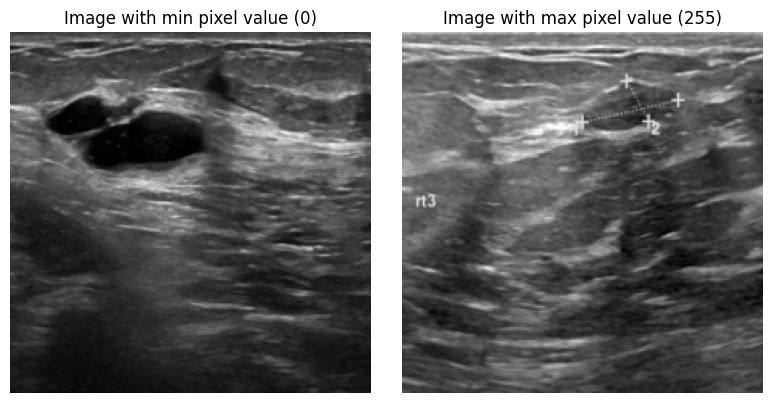

In [11]:
# Visualize images with extreme pixel values

# Find min and max pixel values in all images
min_val = np.min(all_images)
max_val = np.max(all_images)

# Find the indices of images containing the min and max values
min_img_idx = np.where(np.any(all_images == min_val, axis=(1,2)))[0][0]
max_img_idx = np.where(np.any(all_images == max_val, axis=(1,2)))[0][0]

# Show the image with the minimum pixel value
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(all_images[min_img_idx], cmap='gray')
plt.title(f'Image with min pixel value ({min_val})')
plt.axis('off')

# Show the image with the maximum pixel value
plt.subplot(1, 2, 2)
plt.imshow(all_images[max_img_idx], cmap='gray')
plt.title(f'Image with max pixel value ({max_val})')
plt.axis('off')

plt.tight_layout()
plt.show()

Number of outlier images (mean pixel value): 1


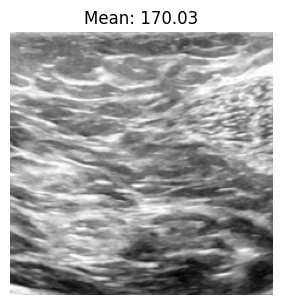

In [12]:
# Detect outlier images based on mean pixel value

# Compute mean pixel value for each image
image_means = all_images.reshape(all_images.shape[0], -1).mean(axis=1)

# Calculate thresholds for outliers (e.g., using 3 standard deviations from the mean)
mean_val = np.mean(image_means)
std_val = np.std(image_means)
lower_threshold = mean_val - 3 * std_val
upper_threshold = mean_val + 3 * std_val

# Find indices of outlier images
outlier_indices = np.where((image_means < lower_threshold) | (image_means > upper_threshold))[0]

print(f"Number of outlier images (mean pixel value): {len(outlier_indices)}")

# Optionally, visualize the outlier images
if len(outlier_indices) > 0:
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(outlier_indices[:5]):  # Show up to 5 outliers
        plt.subplot(1, 5, i + 1)
        plt.imshow(all_images[idx], cmap='gray')
        plt.title(f"Mean: {image_means[idx]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No outlier images found.")

The outlier doesn't seem corrupted, I will keep it since it's just an image with very different brightness and that may be the cause for being considered an outlier

### 2. Προεπεξεργασία Δεδομένων

#### α. Χειρισμός ακραίων τιμών: δεν υπάρχουν ελλειπούσες τιμές και επιλέγω να διατηρήσω το outlier 

#### β. Κανονικοποίηση/Τυποποίηση χαρακτηριστικών: 
Για την κανονικοποίηση/τυποποίηση των χαρακτηριστικών, εφαρμόστηκε η μέθοδος Standard Scaling (Z-score normalization), ώστε κάθε χαρακτηριστικό να έχει μέση τιμή 0 και τυπική απόκλιση 1. Η επιλογή αυτή έγινε επειδή οι αλγόριθμοι PCA, LDA και Logistic Regression είναι ευαίσθητοι στην κλίμακα των χαρακτηριστικών. Η κατανομή των τιμών πριν και μετά την τυποποίηση απεικονίστηκε με ιστογράμματα, ενώ παρατηρήθηκε ότι η τυποποίηση βελτιώνει τη διακριτική ικανότητα και τη σύγκλιση των αλγορίθμων.

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_images_flat)
x_val_std = scaler.transform(val_images_flat)  
x_test_std = scaler.transform(test_images_flat)

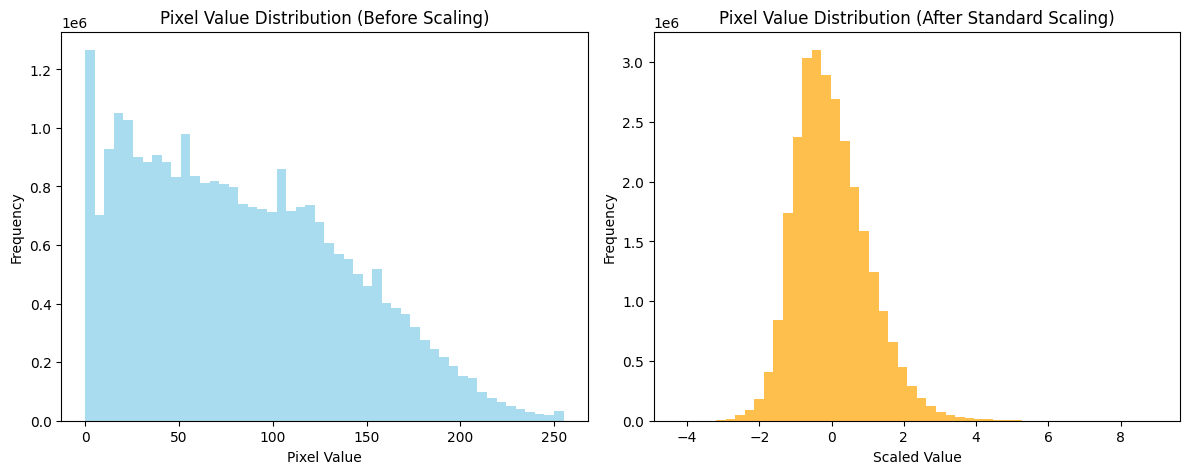

In [14]:
# Visualize pixel value distributions before and after Standard Scaling

# Flatten the training images
flattened_images = x_train.reshape(x_train.shape[0], -1)

# Before scaling
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_images.flatten(), bins=50, color='skyblue', alpha=0.7)
plt.title('Pixel Value Distribution (Before Scaling)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# After scaling
scaler = StandardScaler()
flattened_images_std = scaler.fit_transform(flattened_images)
plt.subplot(1, 2, 2)
plt.hist(flattened_images_std.flatten(), bins=50, color='orange', alpha=0.7)
plt.title('Pixel Value Distribution (After Standard Scaling)')
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
print("Mean pixel value:", np.mean(data['train_images']))
print("Standard deviation of pixel values:", np.std(data['train_images']))

print("Mean pixel value after scaling:", np.mean(flattened_images_std))
print("Standard deviation of pixel values after scaling:", np.std(flattened_images_std))

Mean pixel value: 83.56028899154099
Standard deviation of pixel values: 55.95538071677974
Mean pixel value after scaling: 2.960428742496773e-17
Standard deviation of pixel values after scaling: 1.0


Ανάλυση επίδρασης:(το αναφέρω και πιο πάνω) scaling improves convergence and performance for most machine learning algorithms, especially those based on distances or projections.

#### γ. Επιλογή και μετασχηματισμός χαρακτηριστικών:

1. Αφαίρεση χαρακτηριστικών με χαμηλή διακύμανση (Remove low-variance features)
You can use VarianceThreshold from scikit-learn to remove features (pixels) with very low variance, which are unlikely to be useful for classification

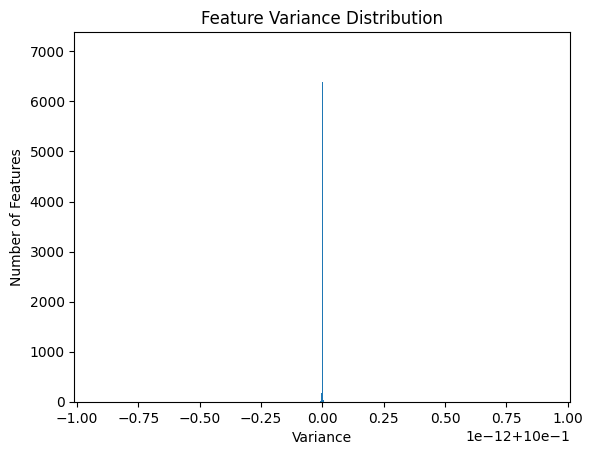

In [16]:
# Calculate variances
variances = x_train_std.var(axis=0)
plt.hist(variances, bins=50)
plt.title("Feature Variance Distribution")
plt.xlabel("Variance")
plt.ylabel("Number of Features")
plt.show()

In [17]:
print("Min variance:", variances.min())
print("Max variance:", variances.max())

Min variance: 0.9999999999999898
Max variance: 1.0000000000000102


In [18]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance below a threshold (e.g., 0.01)
selector = VarianceThreshold(threshold=0.01)
X_train_var = selector.fit_transform(x_train_std)
X_val_var = selector.transform(x_val_std)
X_test_var = selector.transform(x_test_std)

print("Original shape:", x_train_std.shape)
print("After variance thresholding:", X_train_var.shape)

Original shape: (546, 50176)
After variance thresholding: (546, 50176)


2. Δημιουργία νέων χαρακτηριστικών (Feature engineering)
For images, common new features include mean, standard deviation, or other statistics per image. Example:

In [19]:
# Example: Add mean and std of pixel values as new features
train_means = x_train.reshape(x_train.shape[0], -1).mean(axis=1).reshape(-1, 1)
train_stds = x_train.reshape(x_train.shape[0], -1).std(axis=1).reshape(-1, 1)
X_train_fe = np.hstack([X_train_var, train_means, train_stds])

# Repeat for validation and test sets
val_means = x_val.reshape(x_val.shape[0], -1).mean(axis=1).reshape(-1, 1)
val_stds = x_val.reshape(x_val.shape[0], -1).std(axis=1).reshape(-1, 1)
X_val_fe = np.hstack([X_val_var, val_means, val_stds])

test_means = x_test.reshape(x_test.shape[0], -1).mean(axis=1).reshape(-1, 1)
test_stds = x_test.reshape(x_test.shape[0], -1).std(axis=1).reshape(-1, 1)
X_test_fe = np.hstack([X_test_var, test_means, test_stds])

3. Εφαρμογή πολυωνυμικών χαρακτηριστικών (Polynomial features)
You can use polynomial features if you want to capture interactions between pixels (not common for images, but possible for tabular data):

In [20]:
from sklearn.preprocessing import PolynomialFeatures

# Example: Use only a subset of features for demonstration (e.g., first 10)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_var[:, :10])
print("Shape with polynomial features:", X_train_poly.shape)

Shape with polynomial features: (546, 65)


4. Αιτιολόγηση των μετασχηματισμών
Αφαίρεση χαμηλής διακύμανσης: Αφαιρεί άχρηστα χαρακτηριστικά που δεν προσφέρουν πληροφορία.
Feature engineering: Προσθέτει στατιστικά που μπορεί να βοηθήσουν στη διάκριση των κατηγοριών.
Πολυωνυμικά χαρακτηριστικά: Επιτρέπουν στο μοντέλο να μάθει μη γραμμικές σχέσεις, αν και για εικόνες συνήθως δεν χρησιμοποιούνται λόγω του μεγάλου αριθμού χαρακτηριστικών.
Συμπέρασμα:
Εφαρμόζοντας αυτές τις τεχνικές, βελτιώνετε την ποιότητα των χαρακτηριστικών και ενισχύετε τη δυνατότητα του μοντέλου να μάθει σημαντικά μοτίβα από τα δεδομένα σας.
Αιτιολογήστε κάθε βήμα με βάση το πρόβλημα και τα αποτελέσματα που παρατηρείτε.



## Ε. Βαθιά Νευρωνικά Δίκτυα

## MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Κωδικοποίηση των ετικετών σε αριθμητική μορφή
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Δημιουργία του μοντέλου MLP με κανονικοποίηση (Dropout και L2 regularization)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

# Ορισμός παραμέτρων μοντέλου
input_size = X_train.shape[1]  # Από το PCA
hidden_size = 128
output_size = len(set(y_train_encoded))

# Δημιουργία του μοντέλου
dropout_rate = 0.3  # Ορισμός του dropout
model = MLP(input_size, hidden_size, output_size, dropout_rate)

# Ορισμός του device (GPU ή CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
model.to(device)

# Μεταφορά των δεδομένων στην GPU
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long).to(device)

# Ορισμός της συνάρτησης κόστους και του optimizer
criterion = nn.CrossEntropyLoss()  # Χρήση του CrossEntropyLoss για πολυκατηγορηματική ταξινόμηση
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Adam optimizer με L2 regularization (weight_decay)

# Εκπαίδευση του μοντέλου
num_epochs = 20
train_losses = []  # Απώλεια εκπαίδευσης
val_losses = []  # Απώλεια validation
train_accuracies = []  # Ακρίβεια εκπαίδευσης
val_accuracies = []  # Ακρίβεια validation
test_accuracies = []  # Ακρίβεια test

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass για τα δεδομένα εκπαίδευσης
    outputs = model(X_train_tensor)
    _, predicted = torch.max(outputs, 1)
    train_accuracy = accuracy_score(y_train_tensor.cpu(), predicted.cpu())
    train_accuracies.append(train_accuracy)

    # Υπολογισμός απώλειας
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Αποθήκευση της τιμής της απώλειας
    train_losses.append(loss.item())

    # Υπολογισμός και αποθήκευση της ακρίβειας για το validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())  # Αποθήκευση της απώλειας του validation set
        
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val_tensor.cpu(), val_predicted.cpu())
        val_accuracies.append(val_accuracy)

        # Υπολογισμός και αποθήκευση της ακρίβειας για το test set
        test_outputs = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = accuracy_score(y_test_tensor.cpu(), test_predicted.cpu())
        test_accuracies.append(test_accuracy)

    # Εκτύπωση της απώλειας και ακρίβειας κάθε 10 εποχές
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
              f'Train Accuracy: {train_accuracy * 100:.2f}%, '
              f'Validation Accuracy: {val_accuracy * 100:.2f}%, '
              f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Γράφημα με τις Ακρίβειες
plt.figure(figsize=(10, 5))

# Καμπύλες για την ακρίβεια
plt.plot(range(num_epochs), train_accuracies, color='tab:blue', label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, color='tab:green', label='Validation Accuracy')
plt.plot(range(num_epochs), test_accuracies, color='tab:orange', label='Test Accuracy')

# Ρυθμίσεις
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs (Train, Validation & Test)')
plt.legend(loc='lower right')
plt.grid(True)

# Ρύθμιση του άξονα x για να ξεκινάει από 0 και να τελειώνει στο num_epochs - 1
plt.xlim(0, num_epochs - 1)  # Εξασφαλίζουμε ότι το γράφημα τελειώνει στην τελευταία εποχή (20)

plt.show()

# Γράφημα με τις Απώλειες
plt.figure(figsize=(10, 5))

# Καμπύλες για την απώλεια
plt.plot(range(num_epochs), train_losses, color='tab:red', label='Train Loss')
plt.plot(range(num_epochs), val_losses, color='tab:blue', label='Validation Loss')

# Ρυθμίσεις
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (Train & Validation)')
plt.legend(loc='upper right')
plt.grid(True)

# Ρύθμιση του άξονα x για να ξεκινάει από 0 και να τελειώνει στο num_epochs - 1
plt.xlim(0, num_epochs - 1)  # Εξασφαλίζουμε ότι το γράφημα τελειώνει στην τελευταία εποχή (20)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Κωδικοποίηση των ετικετών σε αριθμητική μορφή
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Δημιουργία του μοντέλου MLP με κανονικοποίηση (Dropout και L2 regularization)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        in_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(in_size, hidden_size))
            self.layers.append(activation_function)  # Συναρτήσεις ενεργοποίησης
            self.layers.append(nn.Dropout(dropout_rate))  # Dropout μετά από κάθε κρυφό επίπεδο
            in_size = hidden_size
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output(x)
        return x

# Ορισμός του criterion (συνάρτηση κόστους)
criterion = nn.CrossEntropyLoss()

# Δημιουργία και εκπαίδευση με διαφορετικές υπερπαραμέτρους
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Tanh()]  # Πειραματισμός με συναρτήσεις ενεργοποίησης
hidden_layers_options = [[128, 64], [256, 128], [64, 64, 32]]  # Διάφοροι αριθμοί κρυφών επιπέδων
learning_rates = [0.001, 0.0001, 0.01]  # Διάφοροι ρυθμοί μάθησης
dropout_rates = [0.3, 0.5]  # Διαφορετικοί ρυθμοί dropout

# Αποθήκευση των αποτελεσμάτων για σύγκριση
results = {}

# Ορισμός παραμέτρων μοντέλου
input_size = X_train_pca.shape[1]  # Από το PCA
output_size = len(set(y_train_encoded))  # Από τον αριθμό των κατηγοριών

best_model = None
best_val_accuracy = 0

# Εκπαίδευση με διαφορετικές παραμέτρους
for activation_function in activation_functions:
    for hidden_layers in hidden_layers_options:
        for lr in learning_rates:
            for dropout_rate in dropout_rates:
                
                # Δημιουργία του μοντέλου με τις τρέχουσες υπερπαράμετρους
                model = MLP(input_size, hidden_layers, output_size, dropout_rate, activation_function).to(device)
                
                # Ορισμός του optimizer και της συνάρτησης κόστους
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)  # L2 regularization
                
                # Εκπαίδευση του μοντέλου
                num_epochs = 20
                train_losses = []
                val_losses = []
                train_accuracies = []
                val_accuracies = []
                test_accuracies = []

                for epoch in range(num_epochs):
                    model.train()

                    # Forward pass για τα δεδομένα εκπαίδευσης
                    outputs = model(X_train_tensor)
                    _, predicted = torch.max(outputs, 1)
                    train_accuracy = accuracy_score(y_train_tensor.cpu(), predicted.cpu())
                    train_accuracies.append(train_accuracy)

                    # Υπολογισμός απώλειας
                    loss = criterion(outputs, y_train_tensor)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # Αποθήκευση της τιμής της απώλειας
                    train_losses.append(loss.item())

                    # Υπολογισμός και αποθήκευση της ακρίβειας για το validation set
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(X_val_tensor)
                        val_loss = criterion(val_outputs, y_val_tensor)
                        val_losses.append(val_loss.item())  # Αποθήκευση της απώλειας του validation set

                        _, val_predicted = torch.max(val_outputs, 1)
                        val_accuracy = accuracy_score(y_val_tensor.cpu(), val_predicted.cpu())
                        val_accuracies.append(val_accuracy)

                        # Υπολογισμός και αποθήκευση της ακρίβειας για το test set
                        test_outputs = model(X_test_tensor)
                        _, test_predicted = torch.max(test_outputs, 1)
                        test_accuracy = accuracy_score(y_test_tensor.cpu(), test_predicted.cpu())
                        test_accuracies.append(test_accuracy)

                    # Εκτύπωση της απώλειας και ακρίβειας κάθε 10 εποχές
                    if (epoch+1) % 10 == 0:
                        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
                              f'Train Accuracy: {train_accuracy * 100:.2f}%, '
                              f'Validation Accuracy: {val_accuracy * 100:.2f}%, '
                              f'Test Accuracy: {test_accuracy * 100:.2f}%')

                # Αποθήκευση του μοντέλου με την καλύτερη ακρίβεια validation
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model = model
                    best_hyperparameters = (str(hidden_layers), activation_function.__class__.__name__, lr, dropout_rate)
                    best_result = {
                        'train_losses': train_losses.copy(),
                        'val_losses': val_losses.copy(),
                        'train_accuracies': train_accuracies.copy(),
                        'val_accuracies': val_accuracies.copy()
                    }

                # Αποθήκευση των αποτελεσμάτων για σύγκριση
                results[(str(hidden_layers), str(activation_function), lr, dropout_rate)] = {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                    'test_accuracies': test_accuracies,
                    'model': model  # Προσθήκη του μοντέλου στο dictionary
                }

# Εκτύπωση των βέλτιστων υπερπαραμέτρων
print(f'Best Hyperparameters: {best_hyperparameters}')


# Οπτικοποίηση των αποτελεσμάτων
for param_set, result in results.items():
    train_losses = result['train_losses']
    val_losses = result['val_losses']
    train_accuracies = result['train_accuracies']
    val_accuracies = result['val_accuracies']
    
    plt.figure(figsize=(10, 5))

    # Γράφημα για τις Απώλειες
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss', color='red')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='blue')
    plt.title(f'Losses ({param_set})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Ορισμός του άξονα x ώστε να ξεκινά από το 0
    plt.xlim(0, num_epochs-1)  # Ορίζουμε το x να ξεκινά από το 0
    plt.ylim(min(train_losses + val_losses) - 0.1, max(train_losses + val_losses) + 0.1)

    # Γράφημα για τις Ακρίβειες
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy', color='green')
    plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title(f'Accuracies ({param_set})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Ορισμός του άξονα x ώστε να ξεκινά από το 0
    plt.xlim(0, num_epochs-1)
    plt.ylim(min(train_accuracies + val_accuracies) - 0.05, max(train_accuracies + val_accuracies) + 0.05)

    # Προσαρμογή του layout για να αποφύγουμε την επικαλυπτόμενη περιοχή
    plt.tight_layout()

    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

# Υπολογισμός του Test Loss (χωρίς να το εμφανίσουμε στα γραφήματα)
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)  # Υπολογισμός εξόδου για το test set
    test_loss = criterion(test_outputs, y_test_tensor).item()  # Υπολογισμός του Test Loss

# Εκτύπωση του Test Loss για το καλύτερο μοντέλο
print(f'Test Loss: {test_loss:.4f}')

# Οπτικοποίηση των αποτελεσμάτων χωρίς το Test Loss και Test Accuracy
plt.figure(figsize=(12, 6))

# Γράφημα για τις Απώλειες του καλύτερου μοντέλου
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), best_result['train_losses'], label='Train Loss', color='red')
plt.plot(range(num_epochs), best_result['val_losses'], label='Validation Loss', color='blue')
plt.title(f'Losses for Best Model', pad=20)  # Προσθήκη padding στον τίτλο
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Ορισμός του άξονα x ώστε να ξεκινά από το 0
plt.xlim(0, num_epochs-1)  # Ορίζουμε το x να ξεκινά από το 0
plt.ylim(min(best_result['train_losses'] + best_result['val_losses']) - 0.1, 
         max(best_result['train_losses'] + best_result['val_losses']) + 0.1)

# Γράφημα για τις Ακρίβειες του καλύτερου μοντέλου
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), best_result['train_accuracies'], label='Train Accuracy', color='green')
plt.plot(range(num_epochs), best_result['val_accuracies'], label='Validation Accuracy', color='orange')
plt.title(f'Accuracies for Best Model', pad=20)  # Προσθήκη padding στον τίτλο
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Ορισμός του άξονα x ώστε να ξεκινά από το 0
plt.xlim(0, num_epochs-1)
plt.ylim(min(train_accuracies + val_accuracies) - 0.05, max(train_accuracies + val_accuracies) + 0.05)

# Χρήση του `subplots_adjust` για να αυξήσεις την απόσταση μεταξύ των υποπλοτ
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.preprocessing import label_binarize

# Ελέγχουμε αν η class_names είναι ορισμένη. Αν όχι, τη δημιουργούμε
if 'class_names' not in locals():
    class_names = label_encoder.classes_  # Αν έχεις ήδη τον label_encoder

# Βρίσκουμε τον αριθμό των κατηγοριών από τα δεδομένα
num_classes = len(class_names)  # ή αν είναι ήδη γνωστό, βάλε τον αριθμό απευθείας

# Ελέγχουμε αν η συσκευή (device) είναι ορισμένη
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Υπολογισμός πιθανοτήτων για το test set
with torch.no_grad():
    outputs = best_model(X_test_tensor.to(device))  # Υπολογισμός εξόδου για το test set
    probs = torch.softmax(outputs, dim=1)  # Εφαρμογή softmax για πιθανότητες

# Binarization των ετικετών για το ROC
y_test_bin = label_binarize(y_test_tensor.cpu().numpy(), classes=np.arange(num_classes))

# Υπολογισμός ROC και AUC για κάθε κατηγορία
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i].cpu().numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Σχεδίαση ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Διάσπαση για την τυχαία απόδοση
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Εκτύπωση Classification Report για το Test Set με τα ονόματα των κατηγοριών
y_pred_test = torch.argmax(probs, dim=1).cpu().numpy()  # Ταξινόμηση με τις μεγάλες πιθανότητες
print("Classification Report for Test Set:")
print(classification_report(y_test_tensor.cpu().numpy(), y_pred_test, target_names=class_names))

# Εκτύπωση Classification Report για το Train Set
y_pred_train = torch.argmax(best_model(X_train_tensor.to(device)), dim=1).cpu().numpy()
print("Classification Report for Train Set:")
print(classification_report(y_train_tensor.cpu().numpy(), y_pred_train, target_names=class_names))

# Εκτύπωση Classification Report για το Validation Set
y_pred_val = torch.argmax(best_model(X_val_tensor.to(device)), dim=1).cpu().numpy()
print("Classification Report for Validation Set:")
print(classification_report(y_val_tensor.cpu().numpy(), y_pred_val, target_names=class_names))

# Confusion Matrix για το Test Set
conf_matrix_test = confusion_matrix(y_test_tensor.cpu().numpy(), y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Test Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Confusion Matrix για το Train Set
conf_matrix_train = confusion_matrix(y_train_tensor.cpu().numpy(), y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Train Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Confusion Matrix για το Validation Set
conf_matrix_val = confusion_matrix(y_val_tensor.cpu().numpy(), y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Validation Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()